In [2]:
from data_loader import load_cifar

data = load_cifar()
train, test = data["train"], data["test"]
print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Train set: 50000 samples
Test set: 10000 samples


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

Displaying 2 examples from the CIFAR training set:


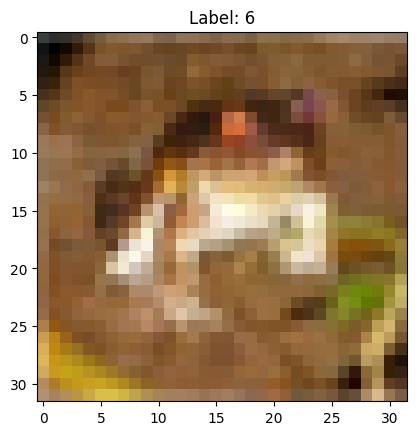

Example 1: Label = 6


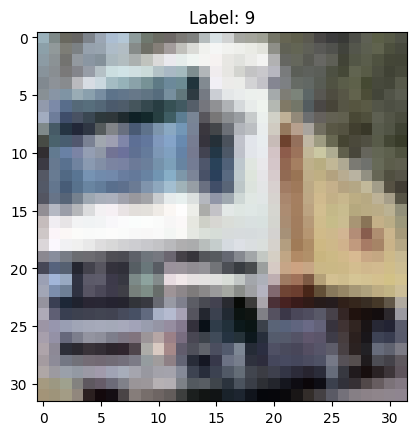

Example 2: Label = 9


In [4]:
train_data = data['train']

print("Displaying 2 examples from the CIFAR training set:")
for i in range(2):
    instance = train_data[i]
    image_matrix = instance['image']
    image_label = instance['label']

    plt.imshow(image_matrix, cmap='gray')
    plt.title(f"Label: {image_label}")
    plt.show()
    print(f"Example {i+1}: Label = {image_label}")

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Initial convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        # Second convolution block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        # Third convolution block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        # Fourth convolution block
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)      # 32x32 -> 16x16
        x = self.conv2(x)      # 16x16 -> 8x8
        x = self.conv3(x)      # 8x8 -> 4x4
        x = self.conv4(x)      # 4x4 -> 2x2
        x = x.view(-1, 512 * 2 * 2)
        return F.log_softmax(x, dim=1)

In [32]:
def prepare_data(raw_data, batch_size=25):
    images = np.array([item['image'] for item in raw_data]).astype(np.float32)
    labels = np.array([item['label'] for item in raw_data]).astype(np.int64)

    # CIFAR-10 images are 32x32x3, so reshape accordingly
    images = images.reshape(-1, 3, 32, 32)  # Changed from (1,28,28) to (3,32,32)
    
    # Normalize pixel values to [0,1]
    images /= 255.0 
    
    # Convert to PyTorch tensors
    tensor_images = torch.from_numpy(images)
    tensor_labels = torch.from_numpy(labels)
    
    # Create dataset and dataloader
    dataset = TensorDataset(tensor_images, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_loader = prepare_data(data['train'])
test_loader = prepare_data(data['test'])


In [ ]:
# Initialize the model
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

model = CNN().to(device)
print(summary(model, input_size=(100, 3, 32, 32)))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()  # NLLLoss instead of CrossEntropyLoss

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    epoch_losses = []
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_totoal_loss = 0.0
        num_batches = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_totoal_loss += loss.item()
            loss_history.append(loss.item())
            num_batches += 1
            
            if batch_idx % 100 == 99:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0
        avg_loss = epoch_totoal_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")
    print("Finished Training")
    return epoch_losses, loss_history

print("Starting training...")
epoch_losses, loss_history = train_model(model, train_loader, criterion, optimizer, epochs=10)

Using device: cuda
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 2048]               2,631,178
├─Sequential: 1-1                        [100, 64, 16, 16]         --
│    └─Conv2d: 2-1                       [100, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 32, 32]         128
│    └─ReLU: 2-3                         [100, 64, 32, 32]         --
│    └─Conv2d: 2-4                       [100, 64, 32, 32]         36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 32, 32]         128
│    └─ReLU: 2-6                         [100, 64, 32, 32]         --
│    └─MaxPool2d: 2-7                    [100, 64, 16, 16]         --
│    └─Dropout: 2-8                      [100, 64, 16, 16]         --
├─Sequential: 1-2                        [100, 128, 8, 8]          --
│    └─Conv2d: 2-9                       [100, 128, 16, 16]        73,856
│    └─BatchNorm2d: 2-10                 [100,

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    return accuracy


print("\nStarting evaluation...")
evaluate_model(model, test_loader)


Starting evaluation...
Accuracy on test set: 61.48%


61.48

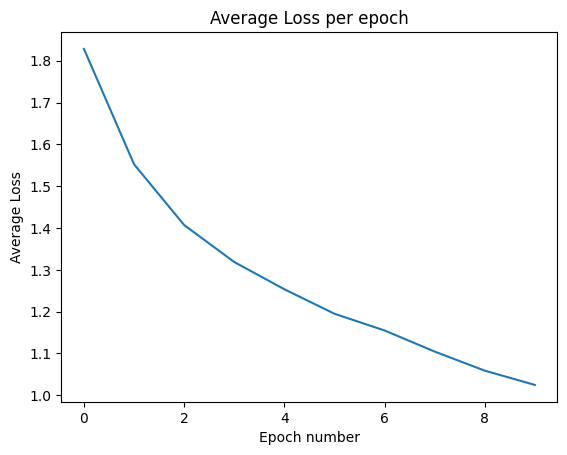

In [13]:
plt.figure()
plt.plot(epoch_losses)
plt.xlabel('Epoch number')
plt.ylabel('Average Loss')
plt.title('Average Loss per epoch')
plt.show()
